In [2]:
from pymongo import MongoClient
client = MongoClient('mongodb://107.155.87.82:26999')
db = client.get_database('steem_posts')
db.authenticate("admin","dmw]SR%u6Ct!", source='admin')
raw_posts = db.get_collection("raw_posts")
mlp = db.get_collection('manually_labeled_posts')

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import bson

In [4]:
def total_weighted_rep(x):
    return sum([rep*weight/10000 for rep, weight in x])

def total_weighted_logrep(x):
    return sum([np.log(max(rep, 1))*weight/10000 for rep, weight in x])

In [5]:
def normalize(ser):
    ser[ser < 0] = 0
    ser = np.log(ser + 1)
    return ser / ser.max()

def query_builder(tresholds):
    neg_query = " | ".join(['({} < {})'.format(metric, lower) for metric, (lower, _) in tresholds.items()])
    pos_query = " & ".join(['({} > {})'.format(metric, upper) for metric, (_, upper) in tresholds.items()])
    return neg_query, pos_query

def label_posts(df, tresholds):
    neg_query, pos_query = query_builder(tresholds)
    normed_df = df.loc[:, tresholds.keys()].apply(normalize)
    neg = normed_df.eval(neg_query)
    pos = normed_df.eval(pos_query)
    return df[neg], df[pos]

def label_posts_indexes(df, tresholds):
    neg, pos = label_posts(df, tresholds)
    return {'neg': neg.index, 'pos': pos.index}

# getting labeled data

In [6]:
_db_labeled = mlp.find()
db_labeled = [i for i in _db_labeled]

In [7]:
labeled_df = pd.DataFrame(db_labeled).set_index('link')

In [8]:
labeled_df.shape

(154, 49)

# Getting sample data

In [13]:
%%time
N_sample = 10000
_sample_data = raw_posts.aggregate([{'$sample':{"size": N_sample}}])
sample_data = [i for i in _sample_data]

In [64]:
sample_df = pd.DataFrame(sample_data).set_index('_id')

# Combining

In [66]:
sample_df = sample_df.loc[~sample_df.identifier.isin(labeled_df.index)]
sample_df.shape

(10000, 45)

In [67]:
comb = sample_df.append(labeled_df)

In [68]:
comb.index.duplicated().sum()

0

In [69]:
comb.score.value_counts(dropna=False)

NaN     10001
 0.0       48
 1.0       20
 3.0       20
 4.0       18
 2.0       16
 5.0       13
 6.0        8
 8.0        5
 7.0        4
 9.0        1
Name: score, dtype: int64

In [10]:
def get_metrics(df):
    df['active_votes'] = df['active_votes'].map(
        lambda y: [(float(x['reputation']), float(x['weight'])) for x in y])
    df['rep'] = df['active_votes'].map(total_weighted_rep)
    df['logrep'] = df['active_votes'].map(total_weighted_logrep)
    df['text_length'] = df['title'].str.len() + 1 + df['body'].str.len()
    
    return df

In [72]:
dfm = get_metrics(comb)

In [73]:
df_stats = dfm[['net_votes', 'total_payout', 'rep', 
               'logrep', 'text_length', 'score']]

df_log_stats = df_stats.copy()
df_log_stats[df_log_stats < 0] = 0
df_log_stats = df_log_stats.applymap(lambda x: np.log(x + 1))
maxes_log_stats = df_log_stats.max()

# Test na sample 10k

In [58]:
tresholds = {
    'net_votes': (0.32, 0.635), 
    'text_length': (0.43, 0.43)
}

neg, pos = label_posts(df_stats, tresholds)
print(neg.shape[0], pos.shape[0])

6708 404


# Test na labelovaných datech

In [11]:
df_stats_labeled = get_metrics(labeled_df)

In [12]:
tresholds = {
    'net_votes': (0.32, 0.635), 
    'text_length': (0.43, 0.43)
}

neg, pos = label_posts(df_stats_labeled, tresholds)
print(neg.shape[0], pos.shape[0])

86 16


In [13]:
neg.score.describe()

count    85.000000
mean      1.705882
std       1.944611
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max       8.000000
Name: score, dtype: float64

In [14]:
pos.score.describe()

count    16.000000
mean      5.875000
std       2.247221
min       2.000000
25%       4.750000
50%       6.500000
75%       8.000000
max       9.000000
Name: score, dtype: float64

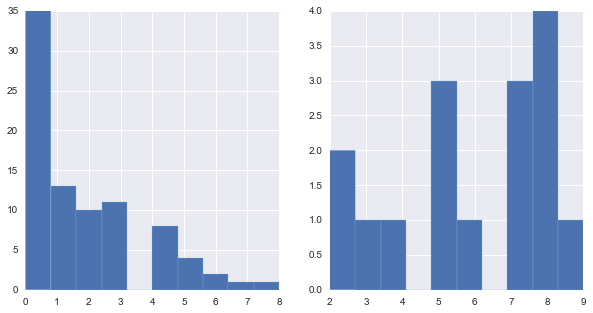

In [30]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
neg.score.hist(ax=ax1)
pos.score.hist(ax=ax2)

Jde vidět, že to jistou separační schopnost dává - distribuce score v pozitivních článcích je větší, než v negativních a poměr pro tohle nastavení docela odpovídá. Asi 40 článků tímhle filterem nebylo vybráno vůbec. Confusion matrix by tady bylo asi nejlepší, nicméně je třeba vybrat treshold říznutí dobrých/špatných dle skore. 

Těch filtrů je samozřejmě možné vyzkoušet více, případně to obalit a udělat automatizovaně na styl gridsearch. Nicméně je otázka, jestli to chceme :-) . 